In [1]:
# from network.Gamma2DCropPaste import StackTPredict, UNet, StackSequenceT , Gamma2DCropPaste, Gamma2DNet
from network.mapGeneratorNet import LSTMNet, Generator, GeneratorPredict
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import numpy as np 
from common.readFiles import *
from matplotlib import pyplot as plt
from policy.PytorchTraining import PytorchRunner
from common.readFiles import *
from common.utils import Logger
import matplotlib.ticker as ticker
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
n_data_file = 13
file_type = 'stochastic'

# map_x, map_y = 20, 20
# # predict_boundary = np.array([[-15, 15], [-15, 15]])
# predict_boundary = np.array([[-200, 200], [-200, 200]])

# log_path = "../output/data/"+file_type+"/old_data/data_{}.txt"
log_path = "../output/data/"+file_type+"/data_{}.txt"

#single data
single_list = ["boundary", "concentration", "position", "water_flow_force"]
time_series_list = ["detect_total_concentration", "detect_water_flow_force", "detect_avg_concentration", "detect_source", "action", "agent_position"]

def getSingleData(logger, variable):
    data = np.array(logger.log[variable])[:, 0]
    if len(data.shape) == 1:
        return np.atleast_2d(data).T
    else: return data

def getTimeSeriesData(logger, variable):
    return np.atleast_3d(logger.log[variable])

logger = Logger()
for i_data_file in range(n_data_file):
    logger.loadLog(log_path.format(i_data_file))

In [3]:
input_variables = ["detect_total_concentration", "detect_water_flow_force"]

def getData(getDataFunction, variables):
    logger = Logger()
    for i_data_file in range(n_data_file):
        # print(i_data_file)
        logger.loadLog(log_path.format(i_data_file))
        for (i_variable, variable) in enumerate(variables):
            data = getDataFunction(logger, variable)
            # print(data.shape)
            if i_variable == 0:
                input_data = data
            else:
                
                input_data =np.concatenate((input_data,data), axis = -1)
                
        if i_data_file == 0:
            output = input_data
        else: output = np.concatenate((output, input_data), axis = 0)
    return output




In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import torch

map_x = 40
# real_range = np.array([[-300, 300], [-300, 300]])
real_range = np.array([[-300, 300], [-300, 300]])
simulated_range = np.array([map_x, map_x])
interval = np.sum(np.abs(real_range), axis=0) / simulated_range

centroid_x = np.array(range(map_x)) - map_x / 2
centroids = np.stack(np.meshgrid(centroid_x, centroid_x), axis=-1)
radius_ring = (real_range[0, 1] - real_range[0, 0]) / map_x / 2


def findAngleArcCos(A, B):
    old_shape = A.shape
    A, B = torch.from_numpy(A).reshape(-1, 2).type(torch.float), torch.from_numpy(B).reshape(-1, 2).type(torch.float)
    # print(A.shape, B.shape)
    cos_between = torch.sum(A * B, axis=-1) / (torch.norm(B, dim=-1) * torch.norm(A, dim=-1))
    error_angle = torch.arccos(cos_between)
    error_angle[torch.isnan(error_angle)] = -1  # bsize, time_len
    return error_angle.reshape(old_shape[:-1]).numpy()


def getAngle(vector, deg=False):
    vector = vector[:, 0] + vector[:, 1] * 1j
    angle = np.angle(vector, deg=deg)
    return angle


def findAngleNpAngle(A, B):
    old_shape = A.shape
    A, B = A.reshape(-1, 2).astype(np.float), B.reshape(-1, 2).astype(np.float)

    angle_between = getAngle(A) - getAngle(B)

    return angle_between.reshape(old_shape[:-1])


def getRotateMatrix(vectors, base=np.array([-1, 0])):
    base_vectors = np.repeat(base[np.newaxis, :], vectors.shape[0], axis=0)

    rotate_angle = findAngleNpAngle(base_vectors, vectors)
    rotate_sin = np.sin(rotate_angle)
    rotate_cos = np.cos(rotate_angle)

    rotate_matrix = np.stack([rotate_cos, -rotate_sin, rotate_sin, rotate_cos], axis=1).reshape(vectors.shape[0], 2, 2)
    return rotate_matrix


def agentPositionRespectWaterFlowForce(agent_pos, water_flow_force):
    rotate_matrix = getRotateMatrix(water_flow_force)
    agent_pos_res_water_flow = np.einsum('aec,abc->abe', rotate_matrix, agent_pos)

    rotated_water_flow = np.einsum('aec, ac -> ae', rotate_matrix, water_flow_force)

    return agent_pos_res_water_flow, rotated_water_flow


def agentPositionRespectSourcePosition(agent_pos, source_pos):
    rotate_matrix = getRotateMatrix(source_pos, base=np.array([1, 0]))
    rotated_source_pos = np.einsum('aec, ac -> ae', rotate_matrix, source_pos)

    agent_pos_res_source_pos = np.einsum('aec,abc->abe', rotate_matrix, agent_pos)
    agent_pos_res_source_pos = agent_pos_res_source_pos - rotated_source_pos[:, np.newaxis, :]

    return agent_pos_res_source_pos, rotated_source_pos


def getShownMap(agent_pos):
    print(agent_pos.shape, centroids.shape)
    agent_pos = agent_pos.reshape(-1, 2)
    agent_pos = (agent_pos - real_range[:, 0]) // interval - (map_x / 2)

    print(agent_pos.shape, centroids.shape)
    distance_map = torch.cdist(torch.tensor(agent_pos, dtype=float), torch.tensor(centroids.reshape(-1, 2),
                                                                                  dtype=float)).numpy()  # bsize, time_len, n_centroids
    distance_map = distance_map.reshape(distance_map.shape[0], map_x, map_x)

    shown_map = distance_map == distance_map.min(axis=(-1, -2))[..., np.newaxis, np.newaxis]
    shown_map = shown_map * (distance_map <= radius_ring)
    shown_map = shown_map.sum(axis=0)

    return shown_map


def processMap(agent_pos, source_pos, water_flow_force, done):
    agent_pos_res_water_flow, rotated_water_flow = agentPositionRespectWaterFlowForce(agent_pos.copy(),
                                                                                      water_flow_force)
    agent_pos_res_source_pos, rotated_source_pos = agentPositionRespectSourcePosition(agent_pos.copy(), source_pos)

    valid = 1 - done
    agent_centric_map = getShownMap(agent_pos[valid])
    source_centric_map = getShownMap(agent_pos_res_source_pos[valid])
    water_centric_map = getShownMap(agent_pos_res_water_flow[valid])

    return agent_centric_map.tolist(), source_centric_map.tolist(), water_centric_map.tolist()

In [142]:
water_flow_force = getData(getSingleData, ['water_flow_force'])
source_pos = getData(getSingleData, ['position'])
agent_action = getData(getTimeSeriesData, ['action'])
agent_pos = getData(getTimeSeriesData, ['agent_position']) #bsize, time_len, 2

In [146]:
agent_pos[0, :10]

array([[ 0,  8],
       [ 0, 16],
       [ 0, 24],
       [ 0, 32],
       [ 0, 40],
       [ 0, 48],
       [ 0, 56],
       [ 8, 56],
       [16, 56],
       [24, 56]])

In [5]:
from common.math import *

In [24]:
n_sample = 2000

water_flow_force = water_flow_force[:n_sample]
source_pos = source_pos[:n_sample]
agent_action = agent_action[:n_sample]
agent_pos = agent_pos[:n_sample]

In [20]:
bsize, time_len = agent_pos.shape[:2]
done = np.zeros((bsize, time_len)).astype(np.bool)

<ipython-input-20-580c40c4ee27>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  done = np.zeros((bsize, time_len)).astype(np.bool)


In [23]:
temp = agent_pos.reshape(-1,2)[1-done.reshape(-1)]
temp.shape

(240000, 2)

In [21]:
agent_centric_map, source_centric_map, water_centric_map = processMap(agent_pos, source_pos, water_flow_force, done)

<ipython-input-18-26f1c70e1be1>:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  A, B = A.reshape(-1, 2).astype(np.float), B.reshape(-1, 2).astype(np.float)


(2000, 120, 120, 2) (40, 40, 2)
(28800000, 2) (40, 40, 2)


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:75] data. DefaultCPUAllocator: not enough memory: you tried to allocate 368640000000 bytes. Buy new RAM!

In [65]:
agent_pos = getData(getTimeSeriesData, ['agent_position']) #bsize, time_len, 2

In [53]:
agent_pos = agent_pos[:, :20, :]

In [25]:
def findAngleArcCos(A, B):
    old_shape = A.shape
    A, B = torch.from_numpy(A).reshape(-1, 2).type(torch.float), torch.from_numpy(B).reshape(-1, 2).type(torch.float)
    # print(A.shape, B.shape)
    cos_between = torch.sum(A * B, axis=-1) / (torch.norm(B, dim=-1) * torch.norm(A, dim=-1))
    error_angle = torch.arccos(cos_between)
    error_angle[torch.isnan(error_angle)] = -1  # bsize, time_len
    return error_angle.reshape(old_shape[:-1]).numpy()

def getAngle(vector, deg = False):
    vector = vector[:,0] + vector[:,1] * 1j
    angle = np.angle(vector, deg = deg)
    return angle

def findAngleNpAngle(A, B):
    old_shape = A.shape
    A, B = A.reshape(-1, 2).astype(np.float), B.reshape(-1, 2).astype(np.float)
    
    angle_between = getAngle(A) - getAngle(B)
    
    return angle_between.reshape(old_shape[:-1])
    





In [26]:
# agent position respect to water flow force
rotate_matrix = getRotateMatrix(water_flow_force)
agent_pos_res_water_flow = np.einsum('aec,abc->abe', rotate_matrix, agent_pos)

rotated_water_flow = np.einsum('aec, ac -> ae', rotate_matrix, water_flow_force)

<ipython-input-25-b645337405a6>:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  A, B = A.reshape(-1, 2).astype(np.float), B.reshape(-1, 2).astype(np.float)


In [129]:
temp_agent_pos = np.ones((2000, 120, 2)) * np.array([0, 8])
temp_agent_pos = np.cumsum(temp_agent_pos, axis = 1)

rotate_matrix = getRotateMatrix(water_flow_force)
agent_pos_res_water_flow = np.einsum('aec,abc->abe', rotate_matrix, temp_agent_pos)

rotated_water_flow = np.einsum('aec, ac -> ae', rotate_matrix, water_flow_force)

<ipython-input-25-b645337405a6>:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  A, B = A.reshape(-1, 2).astype(np.float), B.reshape(-1, 2).astype(np.float)


In [31]:
from simulation.odorSimulation.vector import magnitude
print(water_flow_force[:5])
print(rotated_water_flow[:5])

[[ -0.68506406   2.08422107]
 [ -0.51717954   0.36079096]
 [  4.01929129   0.48456415]
 [-13.38887548   2.82990178]
 [ -1.36745442  -3.01558014]]
[[-2.19392120e+00  4.44089210e-16]
 [-6.30590831e-01  1.11022302e-16]
 [-4.04839535e+00  1.27675648e-15]
 [-1.36846750e+01  3.10862447e-15]
 [-3.31114107e+00 -4.44089210e-16]]


In [69]:
def getTotalDistance(A, B):
    A, B = A.reshape(-1, 2), B.reshape(-1, 2)
    return torch.cdist(torch.tensor(A, dtype=float), torch.tensor(B.reshape(-1, 2),
                                                                                  dtype=float)).numpy()  # bsize, time_len, n_centroids

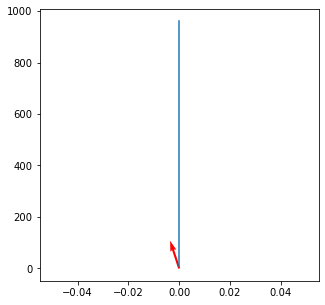

In [81]:
fig = plt.figure(figsize=(5,5))
temp = temp_agent_pos[:1,].reshape(-1, 2)
plt.plot(temp[:, 0], temp[:, 1])
origins = np.array([[0],[0]])

plt.quiver(*origins, water_flow_force[0, 0], water_flow_force[0, 1], color=['r','b','g'], scale=21)

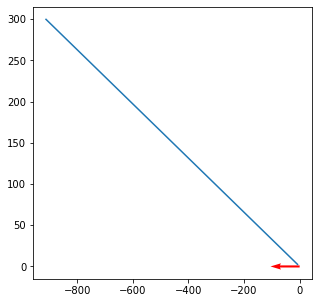

In [82]:
fig = plt.figure(figsize=(5,5))
temp = agent_pos_res_water_flow[:1,].reshape(-1, 2)
plt.plot(temp[:, 0], temp[:, 1])
origins = np.array([[0],[0]])

plt.quiver(*origins, rotated_water_flow[0, 0], rotated_water_flow[0, 1], color=['r','b','g'], scale=21)

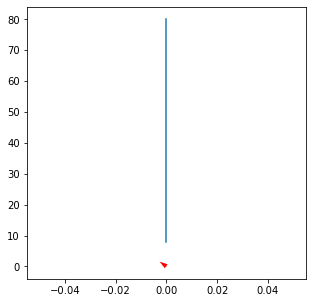

In [65]:
fig = plt.figure(figsize=(5,5))
temp = agent_pos[1:2,:10].reshape(-1, 2)
plt.plot(temp[:, 0], temp[:, 1])
origins = np.array([[0],[0]])
water_flow = water_flow_force[1]
plt.quiver(*origins, water_flow[0], water_flow[1], color=['r','b','g'], scale=21)

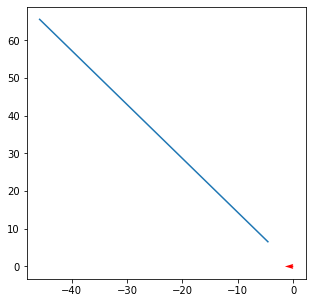

In [66]:
fig = plt.figure(figsize=(5,5))
temp = agent_pos_res_water_flow[1:2,:10].reshape(-1, 2)

plt.plot(temp[:, 0], temp[:, 1])
origins = np.array([[0],[0]])
water_flow = rotated_water_flow[1]
plt.quiver(*origins, water_flow[0], water_flow[1], color=['r','b','g'], scale=21)

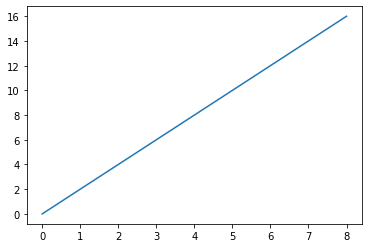

In [41]:
temp = agent_pos[1:2,:10].reshape(-1, 2)
plt.plot(temp[0], temp[1])

In [43]:
agent_pos[0:1,:10]

array([[[ 0,  8],
        [ 0, 16],
        [ 0, 24],
        [ 0, 32],
        [ 0, 40],
        [ 0, 48],
        [ 0, 56],
        [ 8, 56],
        [16, 56],
        [24, 56]]])

In [67]:
# agent position respect to source location
rotate_matrix = getRotateMatrix(source_pos, base = np.array([1, 0]))
rotated_source_pos = np.einsum('aec, ac -> ae', rotate_matrix, source_pos)

agent_pos_res_source_pos = np.einsum('aec,abc->abe', rotate_matrix, agent_pos)
agent_pos_res_source_pos = agent_pos_res_source_pos - rotated_source_pos[:, np.newaxis, :]

<ipython-input-54-b645337405a6>:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  A, B = A.reshape(-1, 2).astype(np.float), B.reshape(-1, 2).astype(np.float)


In [58]:
def findDist(a, b):
    a, b = torch.tensor(a).reshape(1, 2).type(torch.float), torch.tensor(b).reshape(1,2).type(torch.float)
    return torch.cdist(a,b)

In [19]:
# agent_pos = agent_position[:2000]

map_x = 40
real_range = np.array([[-300, 300], [-300, 300]])
real_range = np.array([[-200, 200], [-200, 200]])
simulated_range = np.array([map_x, map_x])
interval = np.sum(np.abs(real_range), axis = 0) / simulated_range

# simulated_pos = (agent_pos - real_range[:, 0]) // interval - (map_x/2)

In [35]:
interval

array([10., 10.])

In [7]:
centroid_x = np.array(range(map_x)) - map_x/2
centroids = np.stack(np.meshgrid(centroid_x, centroid_x), axis = -1)

In [141]:
def getShownMap(agent_pos, show_source=False):
    agent_pos = agent_pos.reshape(-1, 2)
    # agent_pos = (agent_pos - real_range[:, 0]) // interval - (map_x/2)
    agent_pos = (agent_pos) // interval
    
    distance_map = torch.cdist(torch.tensor(agent_pos, dtype=float), torch.tensor(centroids.reshape(-1, 2), dtype=float)).numpy() # bsize, time_len, n_centroids
    distance_map = distance_map.reshape(distance_map.shape[0], map_x, map_x)

    shown_map = distance_map == distance_map.min(axis=(-1, -2))[..., np.newaxis, np.newaxis]

    # print(distance_map.shape, np.product(distance_map.shape), np.sum((distance_map <= radius_ring)))
    shown_map = shown_map * (distance_map <= 0.5)
    shown_map = shown_map.sum(axis=0)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.contourf(shown_map,cmap = 'magma')
    
    if show_source:
        ax.scatter([20], [20], s = 200)
    
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x- map_x/2) * interval[0]* 0.1 ))
    ax.xaxis.set_major_formatter(ticks_x)

    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x- map_x/2) * interval[0]* 0.1 ))
    ax.yaxis.set_major_formatter(ticks_x)

    # return shown_map

In [91]:
temp_agent_pos[:1, :4] - real_range[:, 0]// interval

array([[[20., 28.],
        [20., 36.],
        [20., 44.],
        [20., 52.]]])

In [112]:
np.set_printoptions(linewidth=200)
print(shown_map)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [138]:
np.set_printoptions(precision=1, threshold=None, edgeitems=None, linewidth=1500)
shown_map[15:, 15:25]

array([[ 96, 110, 108,  98, 128, 133, 115, 123, 107, 114],
       [104, 113, 158, 127, 174, 181, 141, 154, 124, 113],
       [107, 141, 163, 204, 205, 222, 220, 175, 154, 125],
       [112, 139, 199, 298, 335, 363, 323, 216, 155, 116],
       [164, 207, 255, 388, 752, 796, 380, 242, 191, 145],
       [154, 189, 230, 365, 767, 774, 379, 240, 195, 153],
       [103, 137, 207, 299, 388, 371, 280, 211, 153, 109],
       [111, 146, 173, 180, 276, 223, 223, 136, 141, 132],
       [105, 122, 124, 136, 225, 174, 168, 137, 100,  90],
       [116,  93, 101, 127, 171, 116, 139, 133,  93,  90],
       [ 71,  86,  84, 120, 145,  93, 115, 118, 104,  69],
       [ 63,  66,  79, 103, 125,  73, 112,  87,  87,  75],
       [ 67,  67,  77,  93, 107,  61,  89,  77,  90,  80],
       [ 43,  53,  89,  76,  49,  29,  62,  84,  76,  67],
       [ 51,  58,  71,  48,  94,  51,  44,  82,  61,  58],
       [ 54,  55,  64,  52,  89,  46,  42,  65,  49,  71],
       [ 37,  72,  40,  60,  82,  41,  49,  53,  57,  55

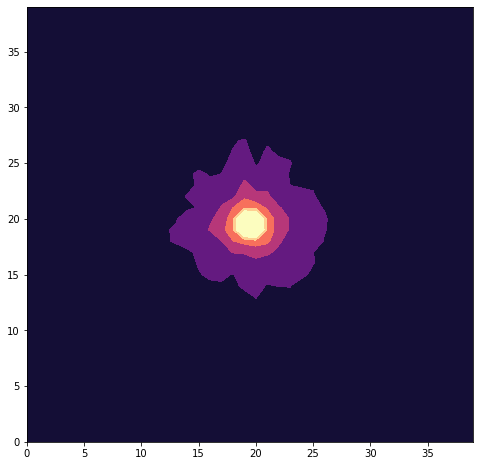

In [140]:
temp = (agent_pos_res_water_flow) // interval
    
temp = temp.reshape(-1, 2)
distance_map = torch.cdist(torch.tensor(temp, dtype=float), torch.tensor(centroids.reshape(-1, 2), dtype=float)).numpy() # bsize, time_len, n_centroids
distance_map = distance_map.reshape(distance_map.shape[0], map_x, map_x)

shown_map = distance_map == distance_map.min(axis=(-1, -2))[..., np.newaxis, np.newaxis]

shown_map = shown_map * (distance_map <= 0.5)

# print(distance_map.shape, np.product(distance_map.shape), np.sum((distance_map <= radius_ring)))
# shown_map = shown_map * (distance_map <= radius_ring)
shown_map = shown_map.sum(axis=0)



fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.contourf(shown_map, cmap='magma', vmax= 500)

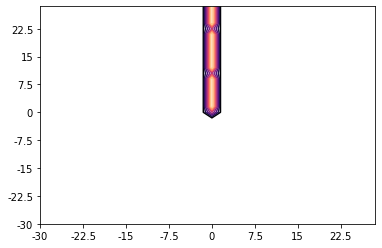

In [127]:
shown_map = getShownMap(temp_agent_pos[:2000])

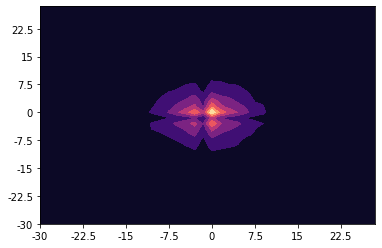

In [122]:
shown_map = getShownMap(agent_pos[:2000])

In [123]:
shown_map = getShownMap(agent_pos_res_source_pos[:2000], show_source = True)

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.contourf(shown_map,cmap = 'magma')

# 

NameError: name 'agent_pos_res_source_pos' is not defined

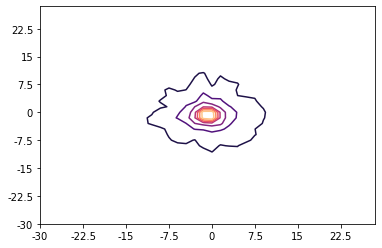

In [128]:
shown_map = getShownMap(agent_pos_res_water_flow[:2000])



In [145]:
rotate_angle_degree = rotate_angle * 180 / np.pi

In [146]:
np.set_printoptions(precision=4, suppress=True)
print(rotated_water_flow[:5])
print(water_flow_force[:5])
print(rotate_angle_degree[:5])

[[ -2.1939   0.    ]
 [ -0.6306   0.    ]
 [ -4.0484   0.    ]
 [-13.6847   0.    ]
 [ -3.3111  -0.    ]]
[[ -0.6851   2.0842]
 [ -0.5172   0.3608]
 [  4.0193   0.4846]
 [-13.3889   2.8299]
 [ -1.3675  -3.0156]]
[ 71.8048  34.9001 173.1256  11.9345 294.3925]


In [131]:
from simulation.odorSimulation.vector import rotate

In [136]:
rotate(water_flow_force[3], rotate_angle[3])

array([-13.6847,   0.    ])

In [135]:
np.matmul(rotate_matrix[4], water_flow_force[4])

array([-3.3111, -0.    ])

In [46]:
agent_action[:5, 0]

array([[1],
       [1],
       [0],
       [0],
       [2]])

In [118]:
temp = rotate_angle[4] + np.pi * 2
print(temp)
print(np.sin(temp), np.cos(temp))

5.138119117091589
-0.9107374396058274 0.4129858546006411


In [56]:
rotated_water_flow = np.einsum('aec, ac ->ae',rotate_matrix, water_flow_force)

In [39]:
base_water_flow_force = np.repeat(np.array([-1, 0])[np.newaxis, :], water_flow_force.shape[0], axis = 0)

In [47]:
print(agent_position.shape)
print(rotate_matrix.shape)

(22000, 120, 2)
(22000, 2, 2)


In [19]:
temp.shape

(22000, 120, 2)